In [9]:
import os, copy, h5py
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
import numpy as np
import pandas as pd
from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import generate_boilerplate_outputfile, extract_unit_dict, temp_dir
from compas_python_utils.cosmic_integration.ClassCOMPAS import COMPASData
from syntheticstellarpopconvolve.starformation_rate_distributions import starformation_rate_distribution_vanSon2023, madau_dickinson_sfr
from syntheticstellarpopconvolve.metallicity_distributions import metallicity_distribution_vanSon2022, compas_log_skew_normal_distribution_metallicity_distribution
from syntheticstellarpopconvolve.general_functions import calculate_bincenters, calculate_bin_edges
from syntheticstellarpopconvolve.cosmology_utils import lookback_time_to_redshift
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import plot_sfr_dict
import matplotlib.pyplot as plt
from population_vis import get_formation_efficiency
import time
import warnings
import scipy
from scipy import stats
from get_ZdepSFRD import skew_metallicity_distribution

Load some compas-specific things as well as efficiencies

1 binary in COMPAS represents 79.11015055714887  solar masses formed
20000000
1582203011.1429775  [Msun]
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid


/Users/alexandermigala/Documents/Github/metallicity_mergers/population_vis.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  eff_ax.legend()


Took 0.0024170875549316406 to find efficiencies


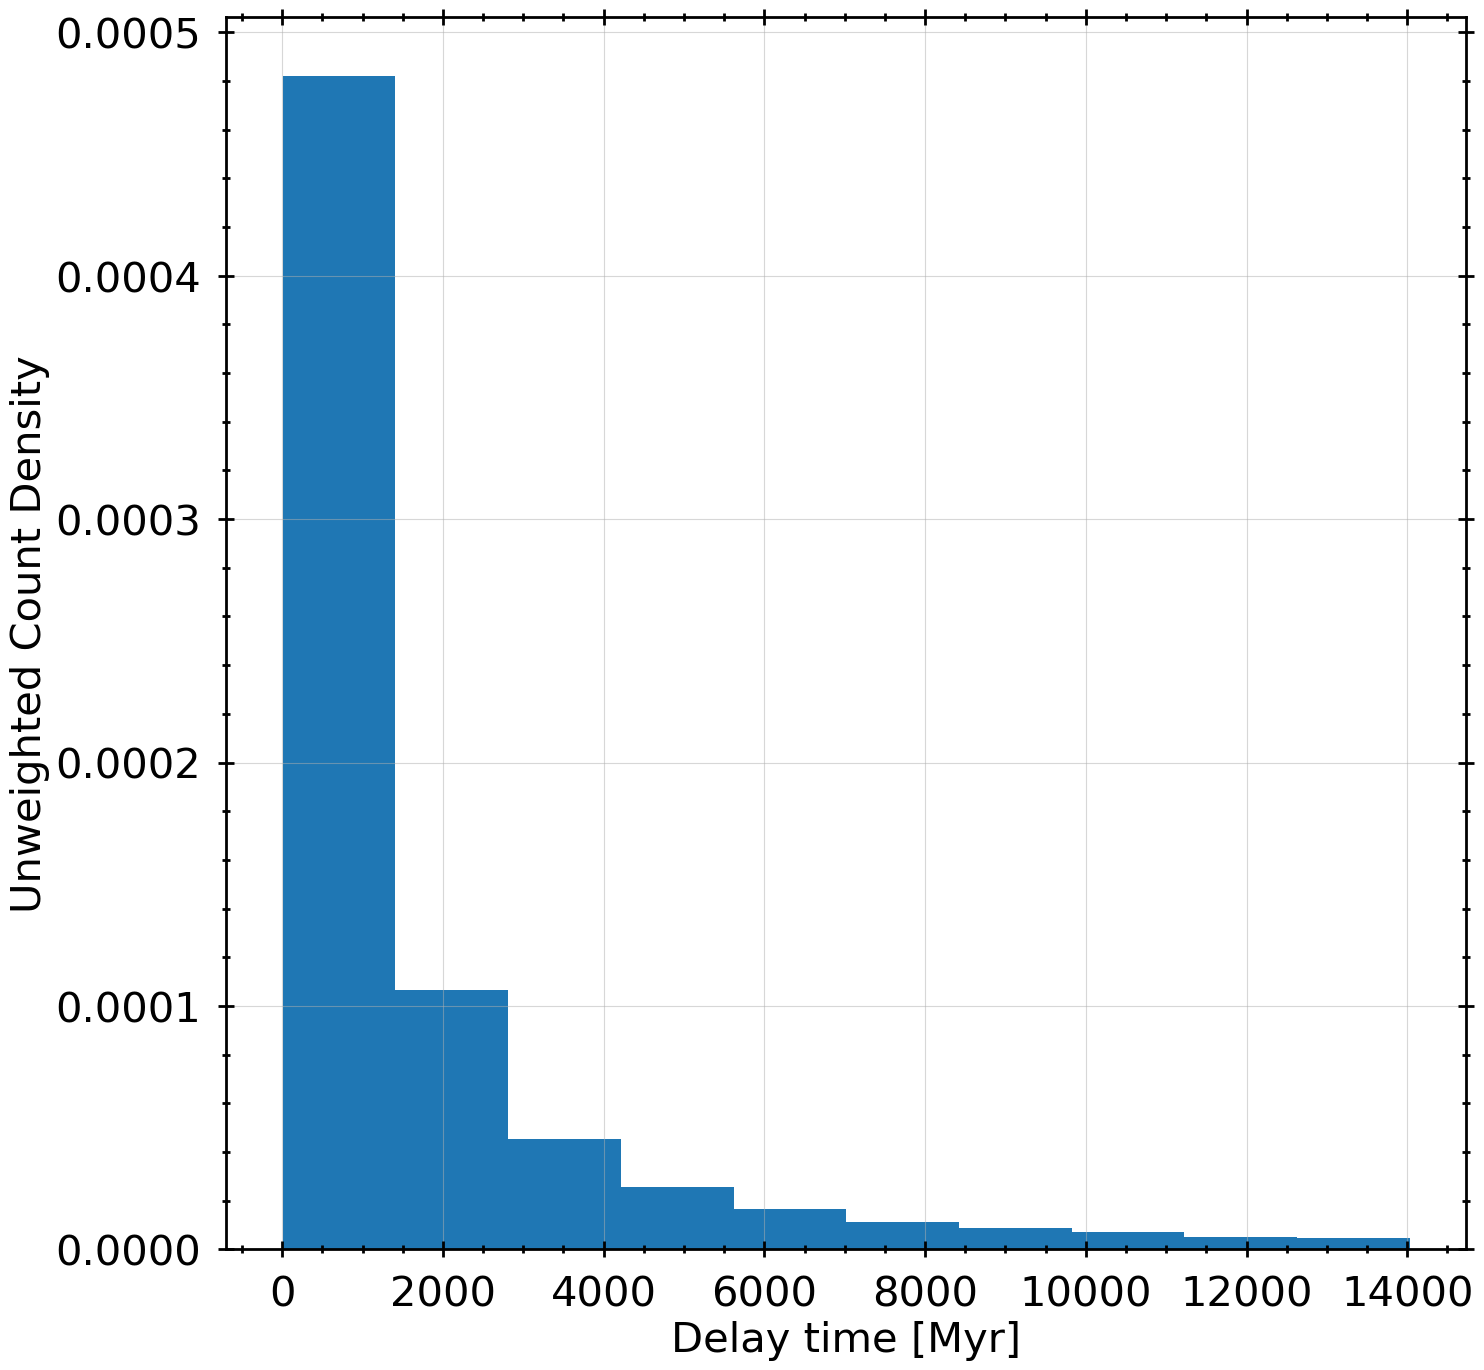

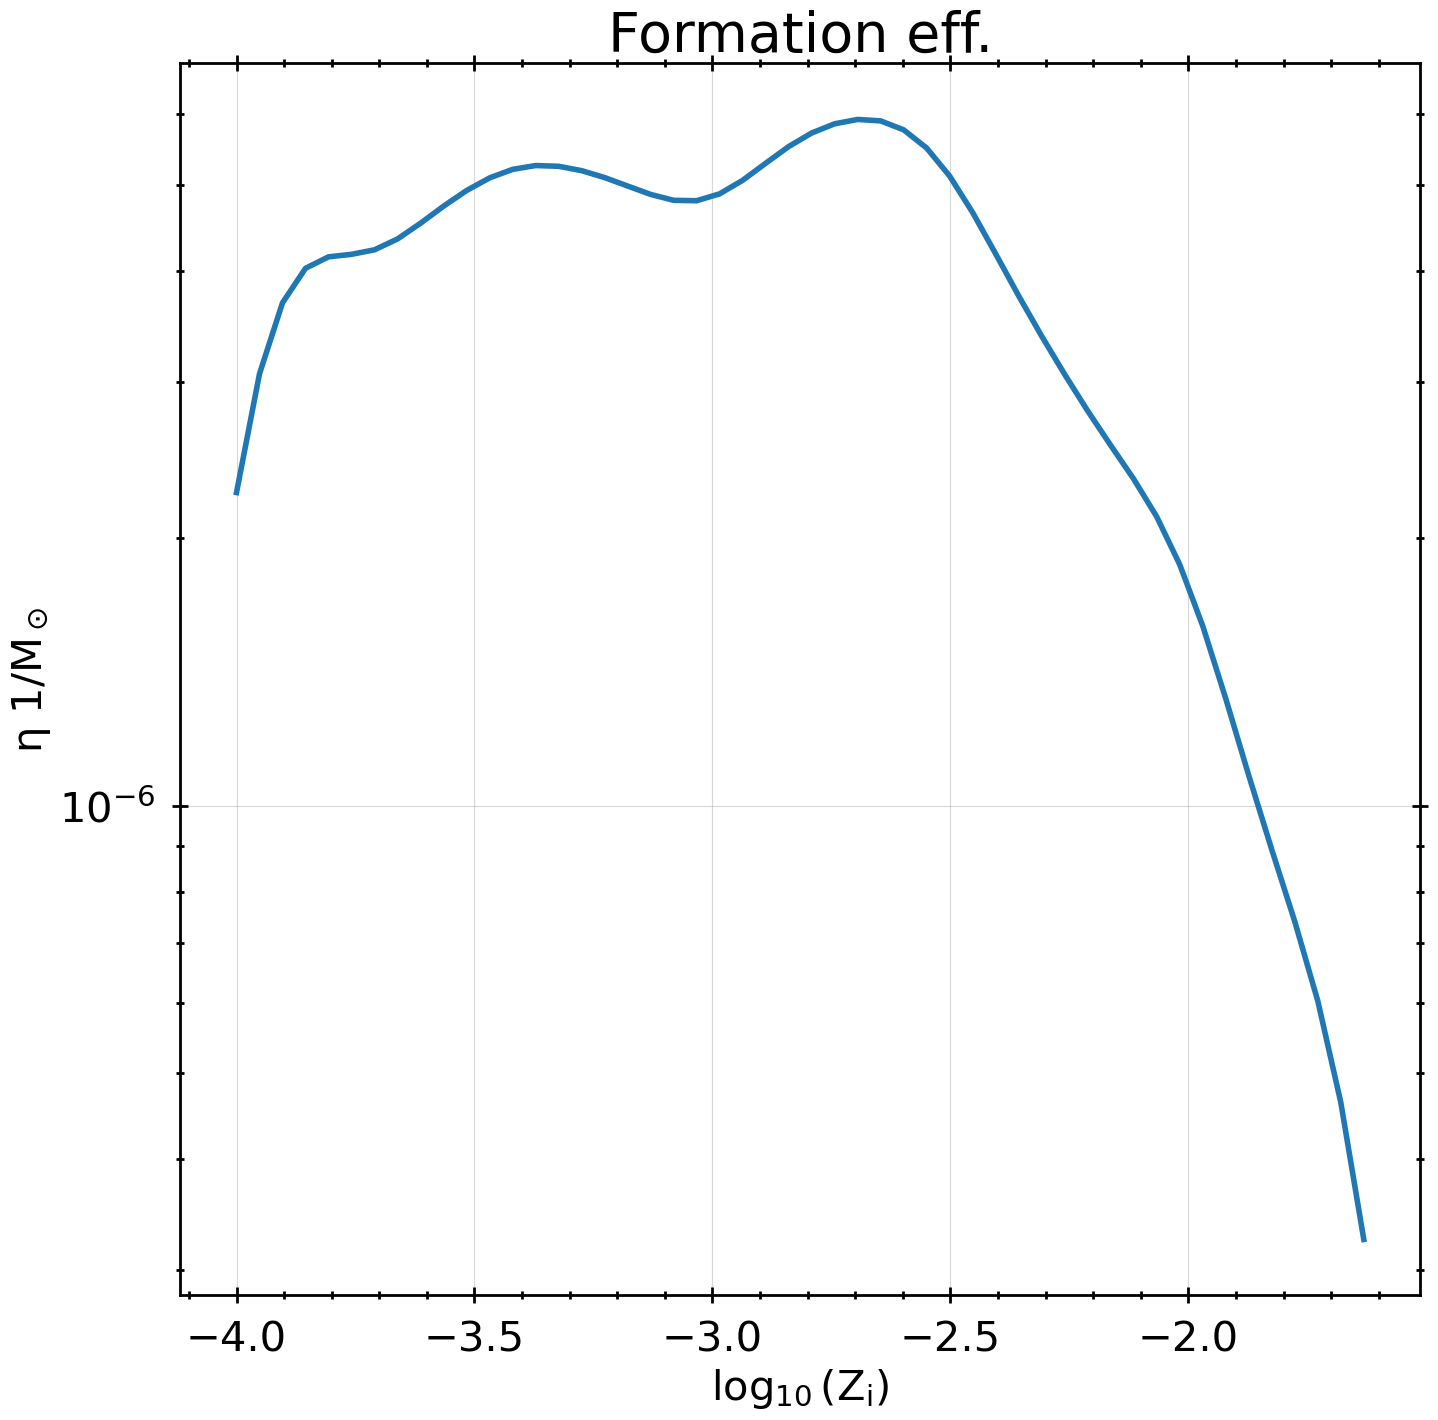

In [10]:
filepath = '/Volumes/Elements/Boesky_sims.h5'

# SET UP DATA -- from a basic dict, port to an h5 file and then store this into the output file
# now we want to use some real data
fdata = h5py.File(filepath)
all_dco_seeds = fdata['BSE_Double_Compact_Objects']['SEED'][()]
all_seeds = fdata['BSE_System_Parameters']['SEED'][()]
metallicities = fdata["BSE_System_Parameters"]["Metallicity@ZAMS(1)"][()]
# potentially mask with/without a stable mass transfer or without an envelope
mixture_weight = fdata["BSE_System_Parameters"]["mixture_weight"][()]
fdata.close()
TYPES = 'BHNS'
fe_binned, fe_bins, compasdata = get_formation_efficiency(filepath, types=TYPES)
delayTimes = compasdata.delayTimes

# need to get the metallicities as well
dco_query = np.isin(all_seeds, all_dco_seeds[compasdata.DCOmask])
dco_metallicities = metallicities[dco_query]
dco_mixture_weight = mixture_weight[dco_query]
assert len(delayTimes[()]) == len(dco_metallicities), "Something went wrong with masking for dco metallicities"
# to query the probabilties, we can digitize the fe_kde using the dco metallicities
# or just use the kde directly -- TODO: maybe one way is more true than the other?
start_time = time.time()
#dco_efficiencies = fe_kde(dco_metallicities) # this is WAY too slow, have to use bins
dco_efficiencies = fe_binned[np.digitize(np.log10(dco_metallicities), (fe_bins[:-1]+fe_bins[1:])/2) - 1]
print(f'Took {time.time() - start_time} to find efficiencies')

In [11]:
class SigmaSkew:
    def __init__(self, sigma0, sigmaz):
        self.sigma0 = sigma0
        self.sigmaz = sigmaz

def returnFractionLogNormal(Zlower, Zupper, redshift, skewoptions=None):
    """
    Instead of combining a GSMF and MZ relation
    you can also directly construct a redshift dependent metallicity distribution

    In this case we focus on a log-normal distribution

    log10(Z) is normally distributed with:

    meanM  = log(Zmean)
                This is redshift dependent and Zmean scales as
                Zmean = Z0 * 10^(alpha * redshift)
                Z0 is the mean metallicity at redshift zero
                alpha is the scaling of the redshift

    sigma  = the standard deviation of log(Z) distribution
                we assume for now that this is redshift independent

    """
    Z0       = 0.035
    alpha    = -0.23
    sigma    = 0.39
    if skewoptions is not None:
        # will also have to deal with the fact that now sigma is an array
        # and no longer a scalar
        sigma = skewoptions.sigma0*(10**(skewoptions.sigmaz*redshift))

    Zmean    = Z0 * (10**(alpha*redshift))
    mu       = np.log(Zmean)  - np.power(sigma,2) /2.
    Xupper   = (np.log(Zupper) - mu)/(float(np.sqrt(2))*sigma)
    CDFUpper = 0.5 + 0.5 * scipy.special.erf(Xupper)
    Xlower   = (np.log(Zlower) - mu)/(float(np.sqrt(2))*sigma)
    CDFLower =  0.5 + 0.5 * scipy.special.erf(Xlower)
    fraction = CDFUpper - CDFLower 
    return fraction

def fractionLogNormalCenter(Z_center, redshift_center, width, diff, options=None):
    # diff = 0.045
    return returnFractionLogNormal(
        Z_center - diff/2,
        Z_center + diff/2,
        redshift_center,
        options
    )/width


In [12]:
class SFROptions:
    def __init__(self, name, mu0, muz, alpha, w0, wz, a, b, c, d):
        self.name = name
        self.mu0 = mu0
        self.muz = muz
        self.alpha = alpha
        self.w0 = w0
        self.wz = wz
        self.a = a
        self.b = b
        self.c = c
        self.d = d

        # setup SFR binning
        self.num_redshift_bins = 400
        self.redshift_bin_edges = np.linspace(0, 10, self.num_redshift_bins)
        self.redshift_bin_centers = calculate_bincenters(self.redshift_bin_edges)
        # setup metallicity binning
        self.num_metallicities = 500

        self.log_metallicity_bin_edges = np.logspace(
            np.log10(np.min(dco_metallicities)),
            np.log10(np.max(dco_metallicities)),
            self.num_metallicities
        )

        # self.log_metallicity_bin_edges = np.log10(self.log_metallicity_bin_edges)
        
        self.log_metallicity_bin_centers = calculate_bincenters(self.log_metallicity_bin_edges)
        # self.metallicity_bin_edges = np.exp(self.log_metallicity_bin_edges)
        # self.metallicity_bin_centers = np.exp(self.log_metallicity_bin_centers)
        
    def __str__(self):
        # return f'{self.mu0}_{self.muz}_{self.alpha}_{self.w0}_{self.wz}_{self.a}_{self.b}_{self.c}_{self.d}'
        return str(self.name)
    def calculate_sfr(self):
        # Set up SFR, and hopefully also setup metallicity dependence
        return madau_dickinson_sfr(
            self.redshift_bin_centers,
            self.a,
            self.b,
            self.c,
            self.d
        ).to(u.Msun/u.yr/u.Gpc**3)
    
    def metallicity_distro_mirror(self, extended_Z_min, extended_Z_max, Zs):
        Zs_min = np.min(np.log10(Zs))
        Zs_max = np.max(np.log10(Zs))

        support_min_loc = np.digitize(Zs_min, self.log_metallicity_bin_centers)-1
        support_max_loc = np.digitize(Zs_max, self.log_metallicity_bin_centers)-1
        # now count the number of bins in the support and then uniformly sample outside the support
        uniform_sampling = support_max_loc-support_min_loc
        lower_tail_locations = np.digitize(np.geomspace(extended_Z_min, Zs_min, uniform_sampling), self.log_metallicity_bin_centers) - 1
        upper_tail_locations = np.digitize(np.geomspace(Zs_max, extended_Z_max, uniform_sampling), self.log_metallicity_bin_centers) - 1
        # now add these tails
        lower_tail_reversed = self.calculate_metallicity_distro()[:, lower_tail_locations][:,::-1]
        upper_tail_reversed = self.calculate_metallicity_distro()[:, upper_tail_locations][:,::-1]

        lt_padded = np.pad(lower_tail_reversed, ((0,0), (support_min_loc, len(self.log_metallicity_bin_centers)-support_max_loc)), 'constant')
        ut_padded = np.pad(upper_tail_reversed, ((0,0), (support_min_loc, len(self.log_metallicity_bin_centers)-support_max_loc)), 'constant')

        self.log_metallicity_bin_edges = np.logspace(
            np.log10(np.min(dco_metallicities)),
            np.log10(np.max(dco_metallicities)),
            self.num_metallicities
        )
        

        return self.calculate_metallicity_distro() + lt_padded + ut_padded

    def calculate_metallicity_distro(self):
        
        # return metallicity_distribution_vanSon2022(self.log_metallicity_bin_centers, self.redshift_bin_centers)
        # we have to evaluate over a meshgrid to get the "image"
        Zmesh, redshiftMesh = np.meshgrid(
        self.log_metallicity_bin_centers,
        self.redshift_bin_centers
        )
        func = fractionLogNormalCenter(
            Zmesh,
            redshiftMesh,
            0.0045,
            np.diff(self.log_metallicity_bin_edges),
            options=SigmaSkew(
                self.w0,
                self.wz
            )
        )
        # return func
        return self.liekecode()
        
    def log_skew_metallicity(self):
        return compas_log_skew_normal_distribution_metallicity_distribution(
            self.redshift_bin_centers,
            self.log_metallicity_bin_centers,
            self.mu0,
            self.muz,
            self.w0,
            self.wz,
            self.alpha
        )
    def liekecode(self):
        dPdlogZ, _, _, _ = skew_metallicity_distribution(
            self.redshift_bin_centers,
            metals=self.log_metallicity_bin_centers
        )
        return dPdlogZ

sfr_van_son = {
    'fiducial': SFROptions(
        'fiducial',
        0.025,
        -0.049,
        -1.70,
        1.129,
        0.048,
        0.02,
        1.48,
        4.44,
        5.90
    ),
    'min': SFROptions(
        'min',
        0.007,
        -0.5,
        -6.0,
        0.7,
        0.0,
        0.01,
        2.60,
        3.20,
        6.20
    ),
    'max': SFROptions(
        'max',
        0.035,
        -0.5,
        0.0,
        2.0,
        0.1,
        0.03,
        2.6,
        3.3,
        5.9
    )
}
def do_convolve_with_sfr_options(options: SFROptions):
    # sadly, can't really save different SFRs in the same file, so we'll need to create a new one each time
    # Create instance of output
    output_hdf5_filename = f'/Volumes/Elements/sspc_output_{str(options)}_{TYPES}.h5'#os.path.join(TMP_DIR, "output_example.h5")
    generate_boilerplate_outputfile(output_hdf5_filename)

    # we need to readjust
    dummy_data = {
            'delay_time': delayTimes[()]*u.Myr,
            'probability': dco_efficiencies,#(10e-4)*np.ones_like(delayTimes[()]),
            'metallicity': dco_metallicities # I wonder if we need to log these as well?
    }
    dummy_df = pd.DataFrame.from_records(dummy_data) # load as dataframe
    dummy_df.to_hdf(output_hdf5_filename, key="input_data/example") # port pandas to hdf

    # Set up global configuration
    convolution_config = copy.copy(default_convolution_config)
    convolution_config["output_filename"] = output_hdf5_filename

    #TODO: assume PLANK13 fit for now
    convolution_config['SFR_info'] = {
        'lookback_time_bin_edges': Planck13.lookback_time(options.redshift_bin_edges),
        'starformation_rate_array': options.calculate_sfr(), # this may have incorrect units!
        'metallicity_bin_edges': options.log_metallicity_bin_edges,
        'metallicity_distribution_array': options.calculate_metallicity_distro()
    }

    # set up convolution bin edges (scales ~linear)
    # ~0.5 is ~1.4gb
    # 0.25 is ~2gb @ 3mins
    # 0.1
    # need to first uniformly sample in redshift then convert to the lookbacktime
    convolution_config["convolution_lookback_time_bin_edges"] = (
        Planck13.lookback_time(np.arange(0, 10, 0.5)).to(u.Gyr)#np.arange(0, 14, 0.5) * u.Gyr
    )

    # Set up the convolution instructions
    convolution_config["convolution_instructions"] = [
        {
            **default_convolution_instruction,
            "input_data_name": "example",
            "output_data_name": "conv_output",
            "data_column_dict": {
                "delay_time": "delay_time",
                "normalized_yield": {"column_name": "probability", "unit": 1/u.Msun},
                'metallicity': 'metallicity'
            }
        }
    ]

    # run convolution
    convolve(convolution_config)

# SFRD Calculations

We want to understand how the SFRD varies with binning the metallicity. Use equation 5 from [Niejssel '19](http://dx.doi.org/10.1093/mnras/stz2840):
$$\frac{d^3M_{SFR}}{dt_sdV_cdZ}(z)=\frac{d^2M_{SFR}}{dt_sdV_c}(z)\times \frac{dP}{dZ}(z)$$
This implies
$$\frac{d^2M_{SFR}}{dt_sdV_c}(z)=\frac{d^2M_{SFR}}{dt_sdV_c}(z)\times \int_{Z_1}^{Z_2}\frac{dP}{dZ}(z)dZ$$
Since we're working with binned data, however, we can treat $z$ as the location of the redshift bin. Then we weight the resulting plot by the weights

/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_78972/2203709384.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  twodfig.show()


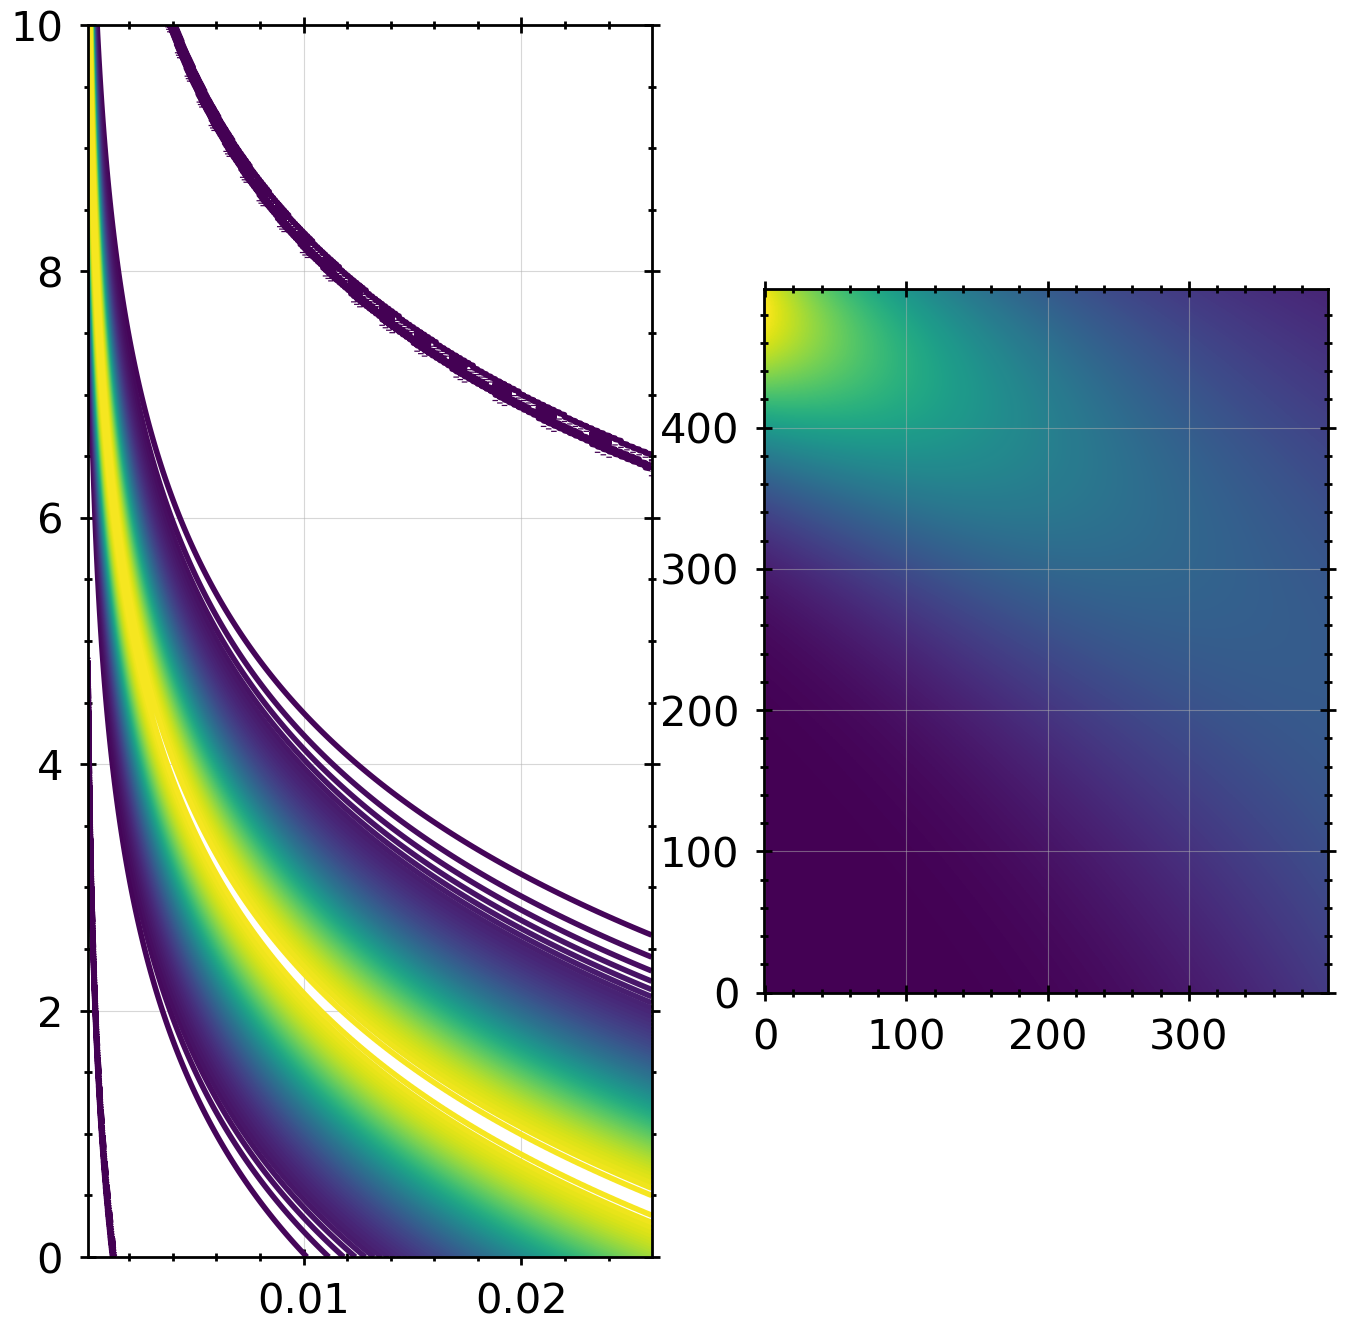

In [13]:
# now let's plot the 2d histogram
# ok now let's do this in 2D. if we can marginalize this correctly then we've done something right
options = sfr_van_son['fiducial']
Zmesh, redshiftMesh = np.meshgrid(
    options.log_metallicity_bin_centers,
    np.linspace(0, 10, 1000)
)
func = fractionLogNormalCenter(Zmesh, redshiftMesh, 0.0045, np.diff(options.log_metallicity_bin_edges))
twodfig, (twodax, imax) = plt.subplots(1,2)
twodax.contour((Zmesh), redshiftMesh, func, levels=100)

# imax.imshow((options.calculate_sfr()[:, np.newaxis].value*options.calculate_metallicity_distro()).T)
imax.imshow(options.calculate_metallicity_distro().T)
imax.invert_yaxis()
twodfig.show()

/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_78972/2189508829.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sfrd_fig.show()
/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_78972/2189508829.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  axis_dict['fig'].show()


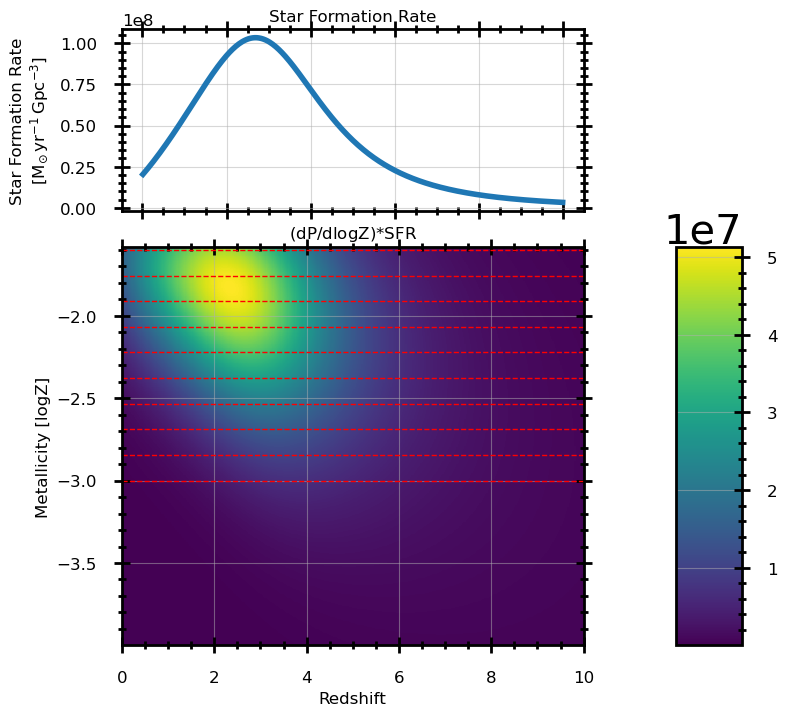

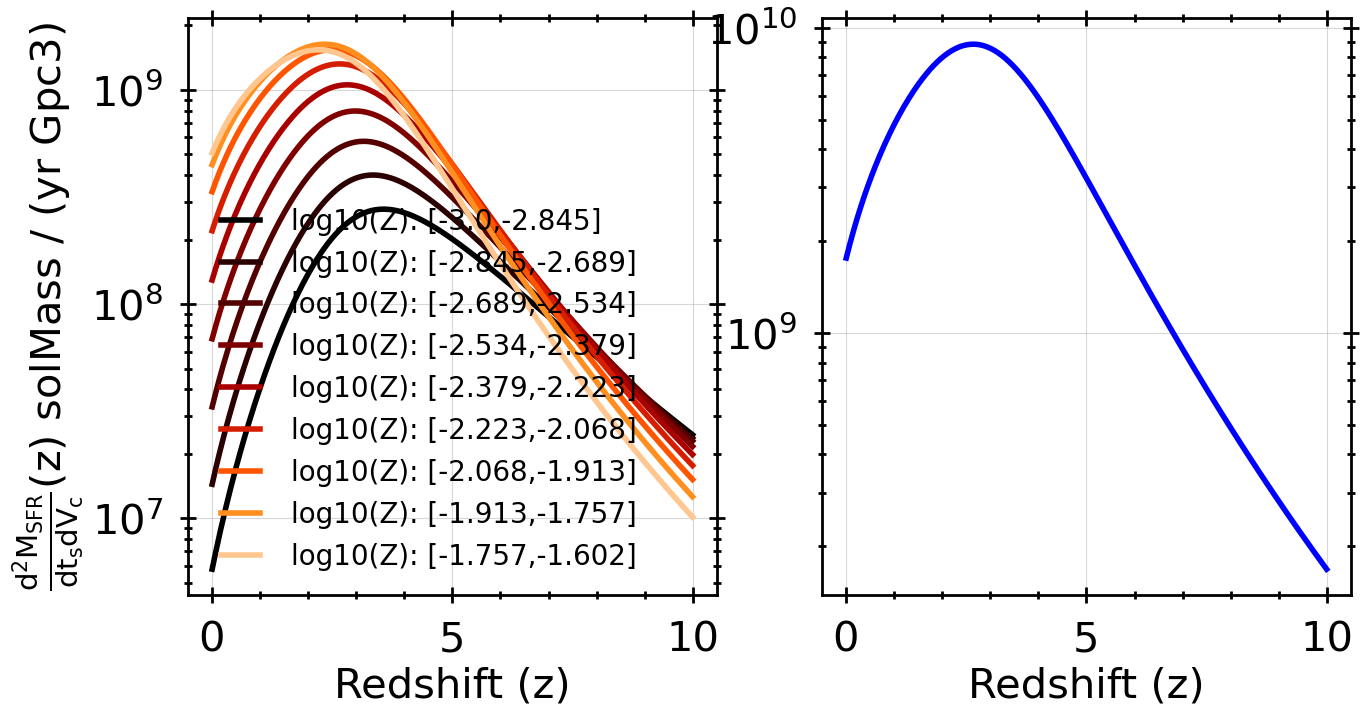

In [14]:
sfr_dict = {
    "redshift_bin_edges": options.redshift_bin_edges,
    "starformation_rate_array": options.calculate_sfr(),
    "metallicity_bin_edges": np.log10(options.log_metallicity_bin_edges),
    "metallicity_distribution_array": options.calculate_metallicity_distro() # We need to transpose!
}
multiply_by_sfr = True
axis_dict = plot_sfr_dict(
    sfr_dict,
    time_type="redshift",
    metallicity_string="logZ",
    metallicity_distribution_multiply_by_metallicity_bin_sizes=False,
    metallicity_distribution_multiply_by_sfr=multiply_by_sfr,
    metallicity_distribution_scale="linear", # can change this to log10 for an easier-to-read image
    metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
    return_axis_dict=True,
    figsize=(8,8),
    fontsize=12,
)

Zbinsizes = np.diff(options.log_metallicity_bin_edges)[np.newaxis, :]
def plot_SFRD_Z_bins(ax, options: SFROptions, Z1: float, Z2: float, color):
    dPdZ = options.calculate_metallicity_distro()#*Zbinsizes
    # dPdZ = options.metallicity_distro_mirror(-5, -0.1, dco_metallicities)

    sfr = options.calculate_sfr()
    Z1=10**(Z1)
    Z2=10**(Z2)
    z1loc = np.digitize(Z1, options.log_metallicity_bin_centers)
    z2loc = np.digitize(Z2, options.log_metallicity_bin_centers)
    # Pz = np.sum((dpdlogZ*(1/metallicity_bin_centers))[:,z1loc:z2loc],axis=1)
    Pz = np.sum(dPdZ[:,z1loc:z2loc], axis=1)
    Z1 = np.log10(Z1).round(3)
    Z2 = np.log10(Z2).round(3)#np.round(Z2,4)
    ax.plot(
        options.redshift_bin_centers,
        Pz*sfr if multiply_by_sfr else Pz,
        label=f'log10(Z): [{Z1},{Z2}]',
        color=color
    )

sfrd_fig, (sfrd_ax, complete_sfrd_ax) = plt.subplots(1, 2, figsize=(15,10*(4.8/6.4)))
# setup log bins
number_bins = 10
Z_min = 0.001
Z_max = 0.025

sfr_m_bins = np.linspace(np.log10(Z_min), np.log10(Z_max), number_bins)
color_bins = plt.cm.gist_heat(np.linspace(0, 1, number_bins))
# print(sfr_m_bins)
# print(np.diff(sfr_m_bins))

for i in range(len(sfr_m_bins) - 1):
    plot_SFRD_Z_bins(
        sfrd_ax, options, sfr_m_bins[i], sfr_m_bins[i+1], color_bins[i]
    )
    axis_dict['ax_mssfr'].axhline(sfr_m_bins[i], color='red', linestyle='dashed', linewidth=1)
    # print(f'Bin location: {sfr_m_bins[i]}')
axis_dict['ax_mssfr'].axhline(sfr_m_bins[-1], color='red', linestyle='dashed', linewidth=1)
plot_SFRD_Z_bins(complete_sfrd_ax, options, np.log10(Z_min), np.log10(Z_max), 'blue')
sfr_title = r'$\frac{d^2M_{SFR}}{dt_sdV_c}(z)$ ' + str(sfr_van_son['fiducial'].calculate_sfr().unit)
Z_title = r'$\int_{Z_1}^{Z_2}\frac{dP(z)}{dZ}dZ$'
sfrd_ax.set_ylabel(sfr_title if multiply_by_sfr else Z_title)
# sfrd_ax.set_ylabel()
sfrd_ax.set_xlabel('Redshift (z)')
sfrd_ax.set_yscale('log')
complete_sfrd_ax.set_yscale('log')
complete_sfrd_ax.set_xlabel('Redshift (z)')
sfrd_ax.legend()
sfrd_fig.show()
# axis_dict['ax_mssfr'].set_yscale('log')
# axis_dict['ax_mssfr'].set_ylim([-1, 0])
# axis_dict['fig'].savefig('./sfr.png')
# check the orange line
# how much total SFRD falls outside the distro

def print_coordinate(Z, z):
    sfr_at_point = options.calculate_sfr()[np.digitize(z, options.redshift_bin_centers) - 1]
    z_loc = np.digitize(z, options.redshift_bin_centers)-1
    Z_loc = np.digitize(Z, options.log_metallicity_bin_centers)-1
    sfrd_at_point = sfr_at_point*(options.calculate_metallicity_distro())[z_loc, Z_loc]
    # axis_dict['ax_mssfr'].scatter(100, 100, color='red', linewidth=20)
    print(sfrd_at_point)
# print_coordinate(-0.5, 1)
# print_coordinate(-0.5, 4)
# print_coordinate(-0.5, 7)
# print_coordinate(-4, 2.1)
# print_coordinate(-4, 9)

axis_dict['fig'].show()

In [15]:
do_convolve_with_sfr_options(sfr_van_son['fiducial'])
# do_convolve_with_sfr_options(sfr_van_son['min'])
# do_convolve_with_sfr_options(sfr_van_son['max'])

In [44]:
def plot_merger_rate_from_hdf_file(options: SFROptions):
    with h5py.File(
            f'/Volumes/Elements/sspc_output_{str(options)}_{TYPES}.h5', "r"
        ) as output_hdf5file:
            groupname = "output_data/example/conv_output/convolution_results/"
            # could try and make an actual merger plot. go through each key, sum the values
            yield_locations = output_hdf5file['output_data/example/conv_output/convolution_results/']
            
            merger_ax_lookbacks = []# np.zeros_like(list(yield_locations.keys()))
            
            # merger_ax_rates_total = []
            y_axis_units = u.Unit(extract_unit_dict(output_hdf5file, groupname + list(yield_locations.keys())[0])['yield']).to_string()

            # for each bin, we want a rate vs redshift
            for r, k in enumerate(yield_locations.keys()):
                # get number
                units = u.Quantity(k).unit
                assert units == u.Gyr, "Rest of plotting code assumes Gyr for lookback time. change conv settings"
                t = u.Quantity(k).value
                if u.Quantity(k) >= u.Quantity('14 Gyr'):
                    warnings.warn('Skipping a data point that was older than the universe..')
                    break
                merger_ax_lookbacks.append(t)
                # merger_ax_rates_total.append(np.sum(yield_locations[k]['yield'][()]))
                # we want to bin by metallicity
                # print(f'lookback: {t}, sum: {merger_ax_rates[r]}')
                # maybe we have to reweight the counts
                # yield_in_bin = yield_locations[k]['yield'][()]
                # counts, _ = np.histogram(yield_in_bin, weights=dco_mixture_weight)
                # merger_ax_rates[r] = np.sum(counts)
                # merger_ax[r].hist(
                #     yield_in_bin,
                #     weights=dco_mixture_weight,
                #     density=True
                # )
            # at this point we have the lookback times available that have also been filtered for unphysical time
            # now we can sort the times
            merger_ax_lookbacks = np.sort(np.array(merger_ax_lookbacks).astype(float))
            merger_rate_number_bins = 5 # keep this consistent for both metallicity and lookback
            # _, merger_metallicity_bins = np.histogram(dco_metallicities, bins=merger_rate_number_bins)
            merger_metallicity_bins = np.linspace(-4, -1.5, merger_rate_number_bins)
            merger_rates_binned_by_metallicities = np.zeros((len(merger_metallicity_bins), len(merger_ax_lookbacks)))
            # now the times are sorted, go through each lookback time, digitize on metallicity
            m_bin_indices = np.digitize(np.log10(dco_metallicities), merger_metallicity_bins)

            # now we'd also like to bin on delay times well
            # _, merger_delay_bins = np.histogram(delayTimes, bins=merger_rate_number_bins)
            # merger_rates_binned_by_delaytimes = np.zeros((len(merger_delay_bins), len(merger_ax_lookbacks)))
            # dt_bin_indices = np.digitize(delayTimes, merger_delay_bins)

            # we also want to get the rates_per_system so we can re-weight later on
            all_weights = np.zeros((len(dco_metallicities), len(merger_ax_lookbacks)))

            for j, lo in enumerate(merger_ax_lookbacks):
                yields = yield_locations[u.Quantity(lo*u.Gyr).to_string()]['yield'][()]
                all_weights[:, j] = yields
                for bin_index in range(len(merger_metallicity_bins)):
                    # go through each bin, sum yields at the locations where the bin is equal
                    
                    bin_query = np.where(m_bin_indices == bin_index+1) 
                    merger_rates_binned_by_metallicities[bin_index][j] = np.sum(
                        yields[bin_query]
                        # weights=metallicity_distro_at_cur_redshift[
                        #     np.digitize(np.log10(dco_metallicities), options.log_metallicity_bin_centers)-1
                        # ][bin_query]
                    )
                
                    # we want to plug in the metallicities to get the probability
                    # merger_rates_binned_by_delaytimes[bin_index][j] = np.sum(yields[np.where(dt_bin_indices == bin_index+1)])

            # merger_ax_rates_total = np.array(merger_ax_rates_total).astype(float)
            # assert 0
            merger_ax_lookbacks = [lookback_time_to_redshift(l, Planck13) for l in merger_ax_lookbacks]

            merger_metallicity_bins = np.round(merger_metallicity_bins,2)
            return {
                 'merger_rates_binned_by_metallicities': merger_rates_binned_by_metallicities,
                 'merger_metallicity_bins': merger_metallicity_bins,
                 'redshifts': np.round(merger_ax_lookbacks,2),
                 'y_units': y_axis_units,
                 'all_weights': all_weights
            }
    # if we could derive the detection probabilities (or really just use them using our data) then we can plot
    # the expected mergers with a confidence region
    # see this documentation from LIGO https://emfollow.docs.ligo.org/userguide/capabilities.html

fiducial_plotting_data = plot_merger_rate_from_hdf_file(sfr_van_son['fiducial'])
# probably going to need a way to save this to a numpy file or something
import pickle
with open('test.pkl', 'wb') as p:
    pickle.dump(fiducial_plotting_data, p)

# min_plotting_data = plot_merger_rate_from_hdf_file(sfr_van_son['min'])
# max_plotting_data = plot_merger_rate_from_hdf_file(sfr_van_son['max'])

Plot by binning on metallicity

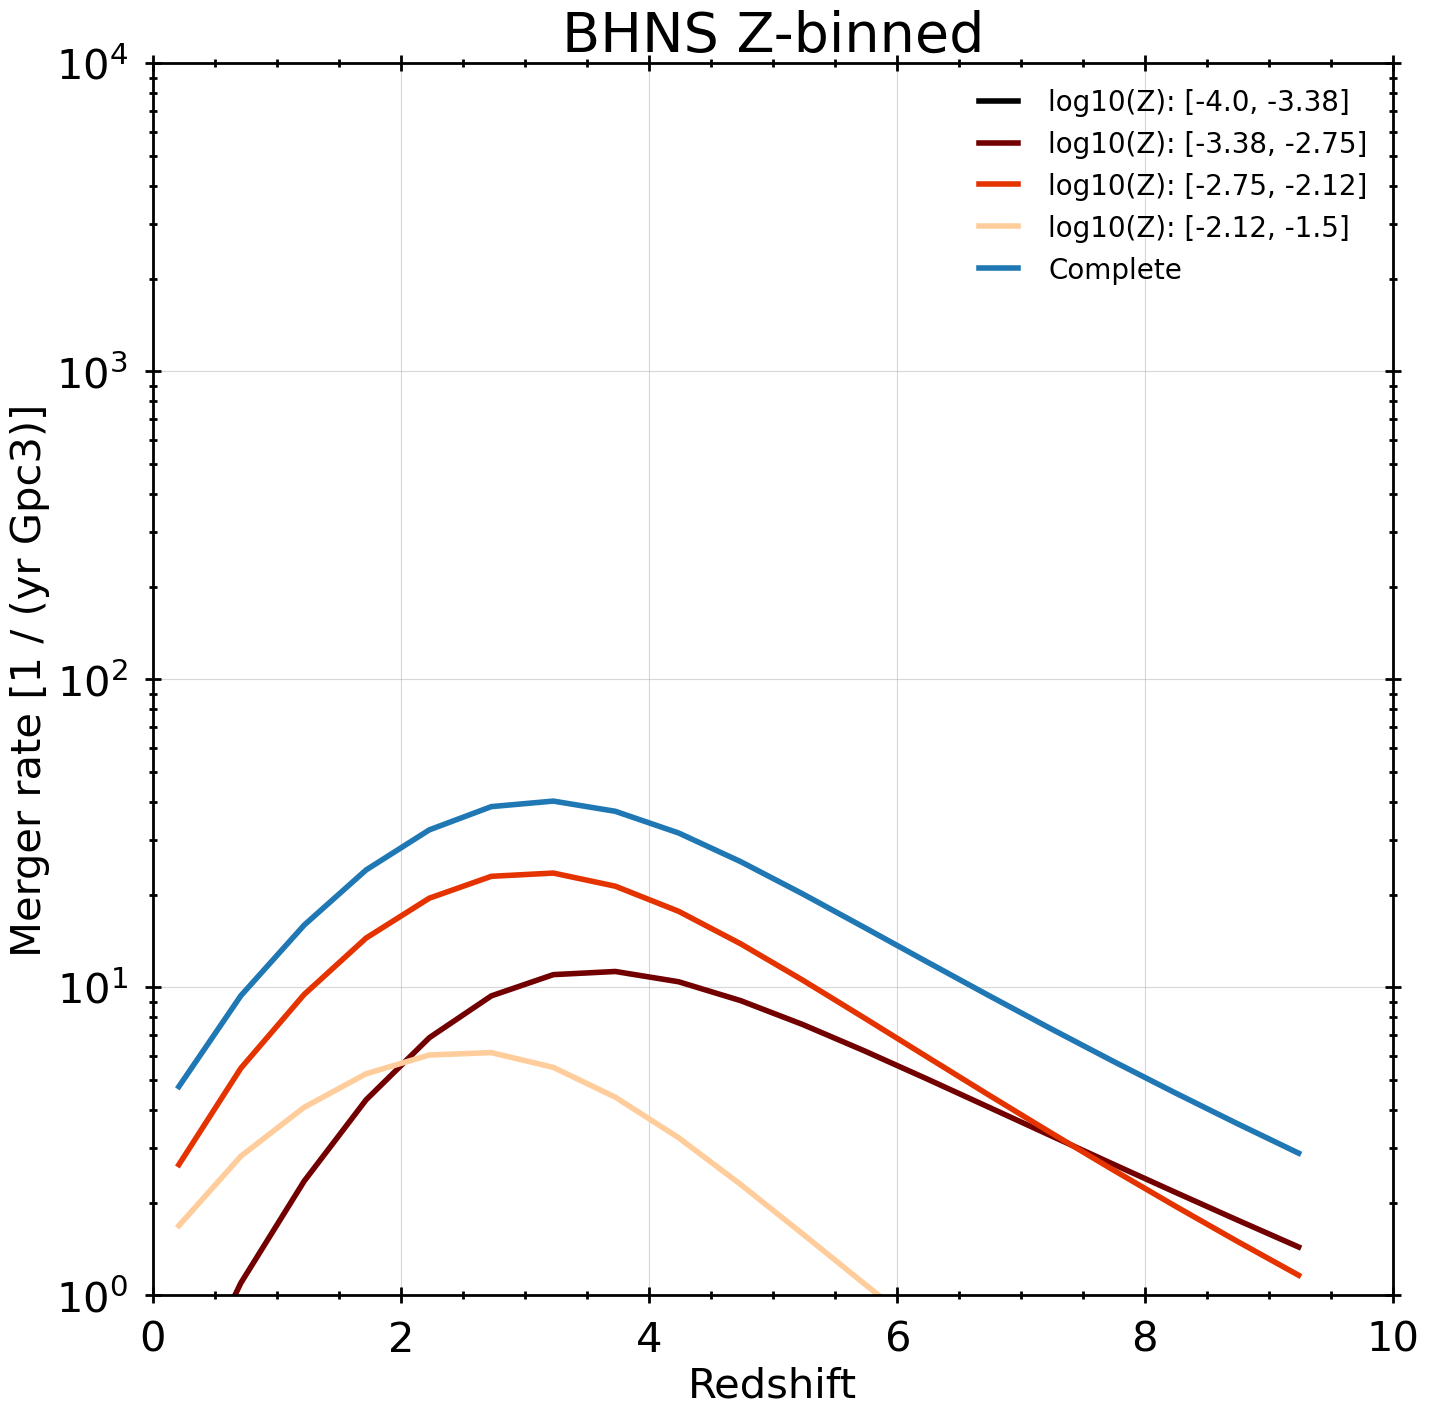

In [18]:
import matplotlib.ticker as mticker


merger_fig, merger_ax = plt.subplots(1, 1)
# merger_ax.set_ylim(np.min(merger_ax_rates), np.max(merger_ax_rates))
merger_ax.yaxis.set_inverted(False)  # ensure not inverted

# restore auto ticks/labels
merger_ax.yaxis.set_major_locator(mticker.AutoLocator()) #from GPT. something was wrong with matplotlib
merger_ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

# merger_ax.plot(
# np.round(fiducial_plotting_data['merger_ax_lookbacks'],2),
# np.sum(fiducial_plotting_data['merger_rates_binned_by_metallicities'],axis=0),
# label='Complete'
# )
color_bins = plt.cm.gist_heat(np.linspace(0, 0.9, fiducial_plotting_data['merger_rates_binned_by_metallicities'].shape[0]-1))
for bi in range(fiducial_plotting_data['merger_rates_binned_by_metallicities'].shape[0]-1):     
    merger_ax.plot(
        np.round(fiducial_plotting_data['redshifts'],2),
        fiducial_plotting_data['merger_rates_binned_by_metallicities'][bi],
        color=color_bins[bi],
        label=f'log10(Z): [{fiducial_plotting_data['merger_metallicity_bins'][bi]}, {fiducial_plotting_data['merger_metallicity_bins'][bi+1]}]'
    )
    # merger_ax.fill_between(
    #     np.round(fiducial_plotting_data['redshifts'],2),
    #     fiducial_plotting_data['merger_rates_binned_by_metallicities'][bi],
    #     color=color_bins[bi],
    #     alpha=0.1
    # )
    # merger_ax.plot(
    #     np.round(merger_ax_lookbacks,2),
    #     merger_rates_binned_by_delaytimes[bi],
    #     # label=f'log10(Z): [{merger_metallicity_bins[bi]}, {merger_metallicity_bins[bi+1]}]'
    # )

# complete_merger_ax.plot(
#     fiducial_plotting_data['redshifts'],
#     np.sum(fiducial_plotting_data['merger_rates_binned_by_metallicities'],axis=0)
# )

merger_ax.plot(
    fiducial_plotting_data['redshifts'],
    np.sum(fiducial_plotting_data['merger_rates_binned_by_metallicities'],axis=0),
    label='Complete'
)

merger_ax.set_xlabel('Redshift')
# complete_merger_ax.set_xlabel('Redshift')
# merger_ax.set_ylim(sorted(merger_ax.get_ylim()))
merger_ax.set_yscale('log')
# complete_merger_ax.set_yscale('log')

merger_ax.set_ylabel(f'Merger rate [{fiducial_plotting_data['y_units']}]')
merger_ax.legend()
merger_ax.set_title(f'{TYPES} Z-binned')
# complete_merger_ax.set_title('Complete rate')

merger_ax.set_xlim(0, 10)
merger_ax.set_ylim(1,10e3)
# complete_merger_ax.set_xlim(0, 10)
# complete_merger_ax.set_ylim(1,10000)
merger_fig.savefig('merger rates.png')


# Complete Merger Rate Plot

/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_78972/1604844032.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sfr_fig.show()


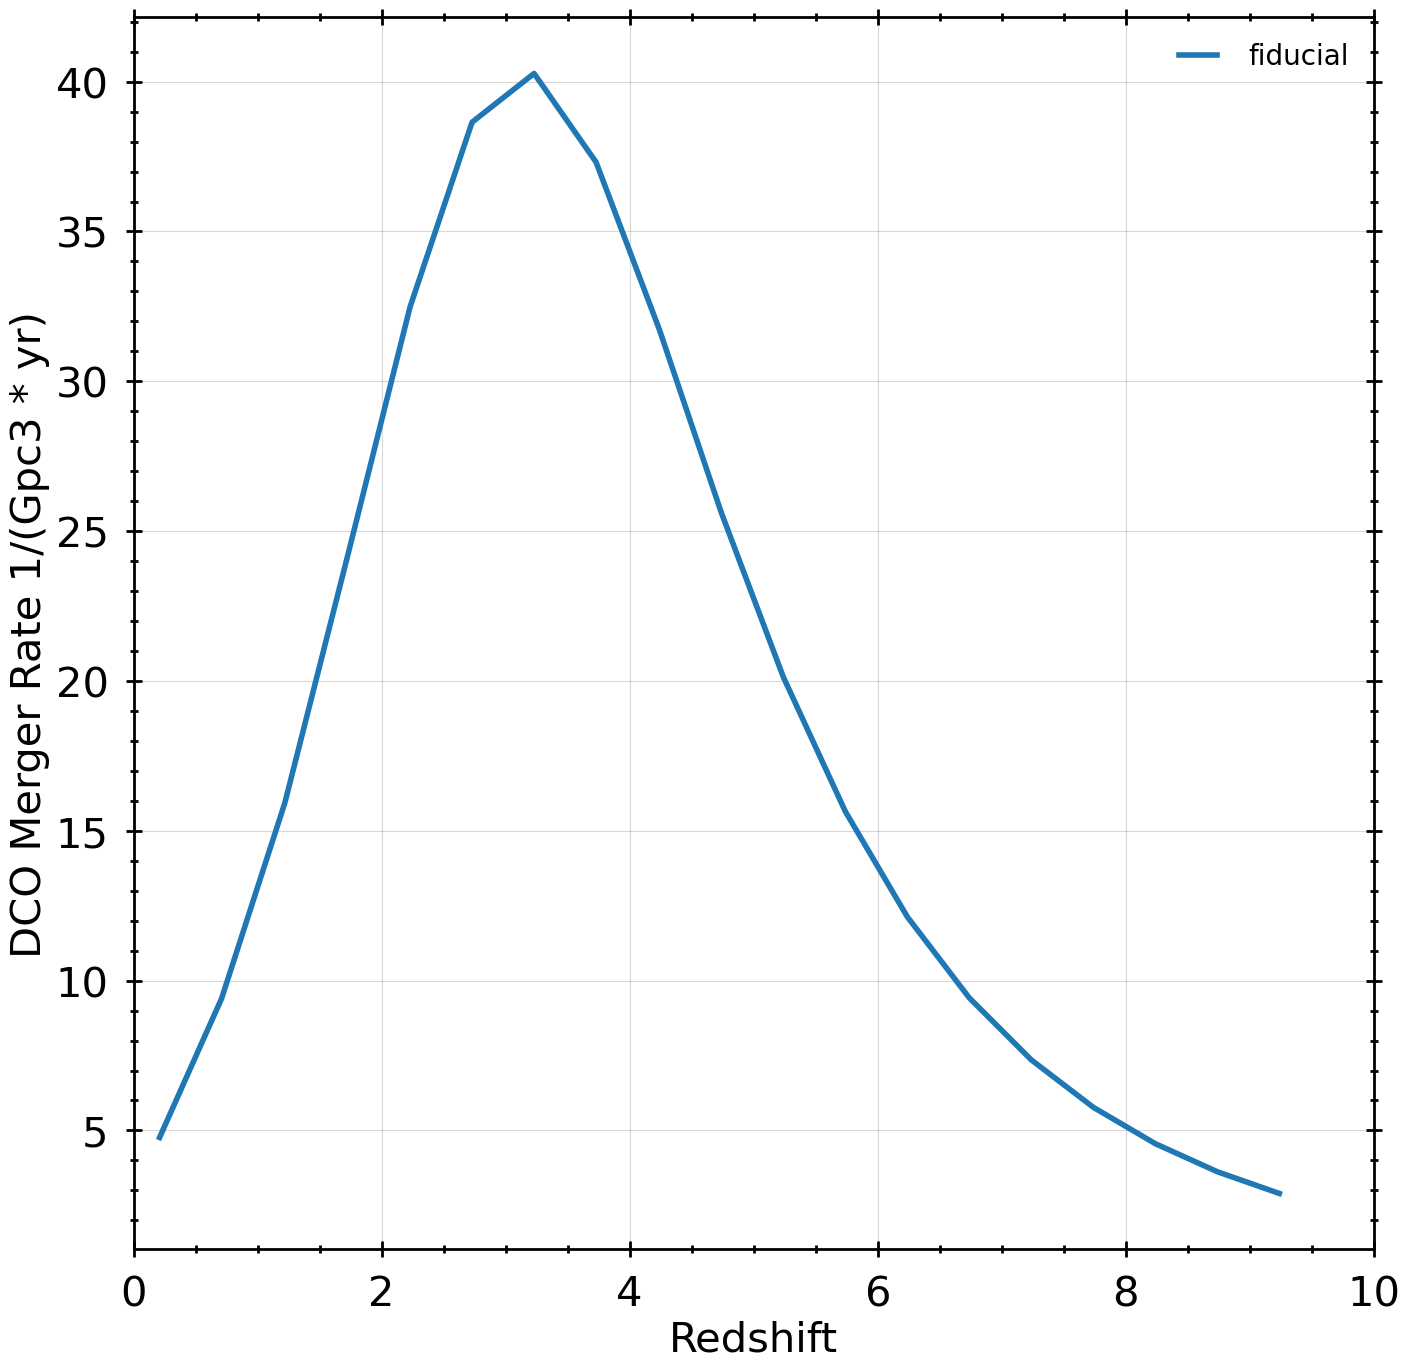

In [19]:

# make a new plot
sfr_fig, sfr_ax = plt.subplots(1, 1)

sfr_ax.plot(
    fiducial_plotting_data['redshifts'],
    np.sum(fiducial_plotting_data['all_weights'],axis=0),
    label='fiducial'
)
# sfr_ax.plot(
#     min_plotting_data['redshifts'],
#     np.sum(min_plotting_data['merger_rates_binned_by_metallicities'],axis=0),
#     label='min'
# )
# sfr_ax.plot(
#     max_plotting_data['redshifts'],
#     np.sum(max_plotting_data['merger_rates_binned_by_metallicities'],axis=0),
#     label='max'
# )
# sfr_ax.set_yscale('log')
sfr_ax.set_xlabel('Redshift')
sfr_ax.set_ylabel('DCO Merger Rate 1/(Gpc3 * yr)')
sfr_ax.set_xlim(0, 10)
sfr_ax.legend()
sfr_fig.show()

# Make the metallicity plot

NameError: name 'min_plotting_data' is not defined

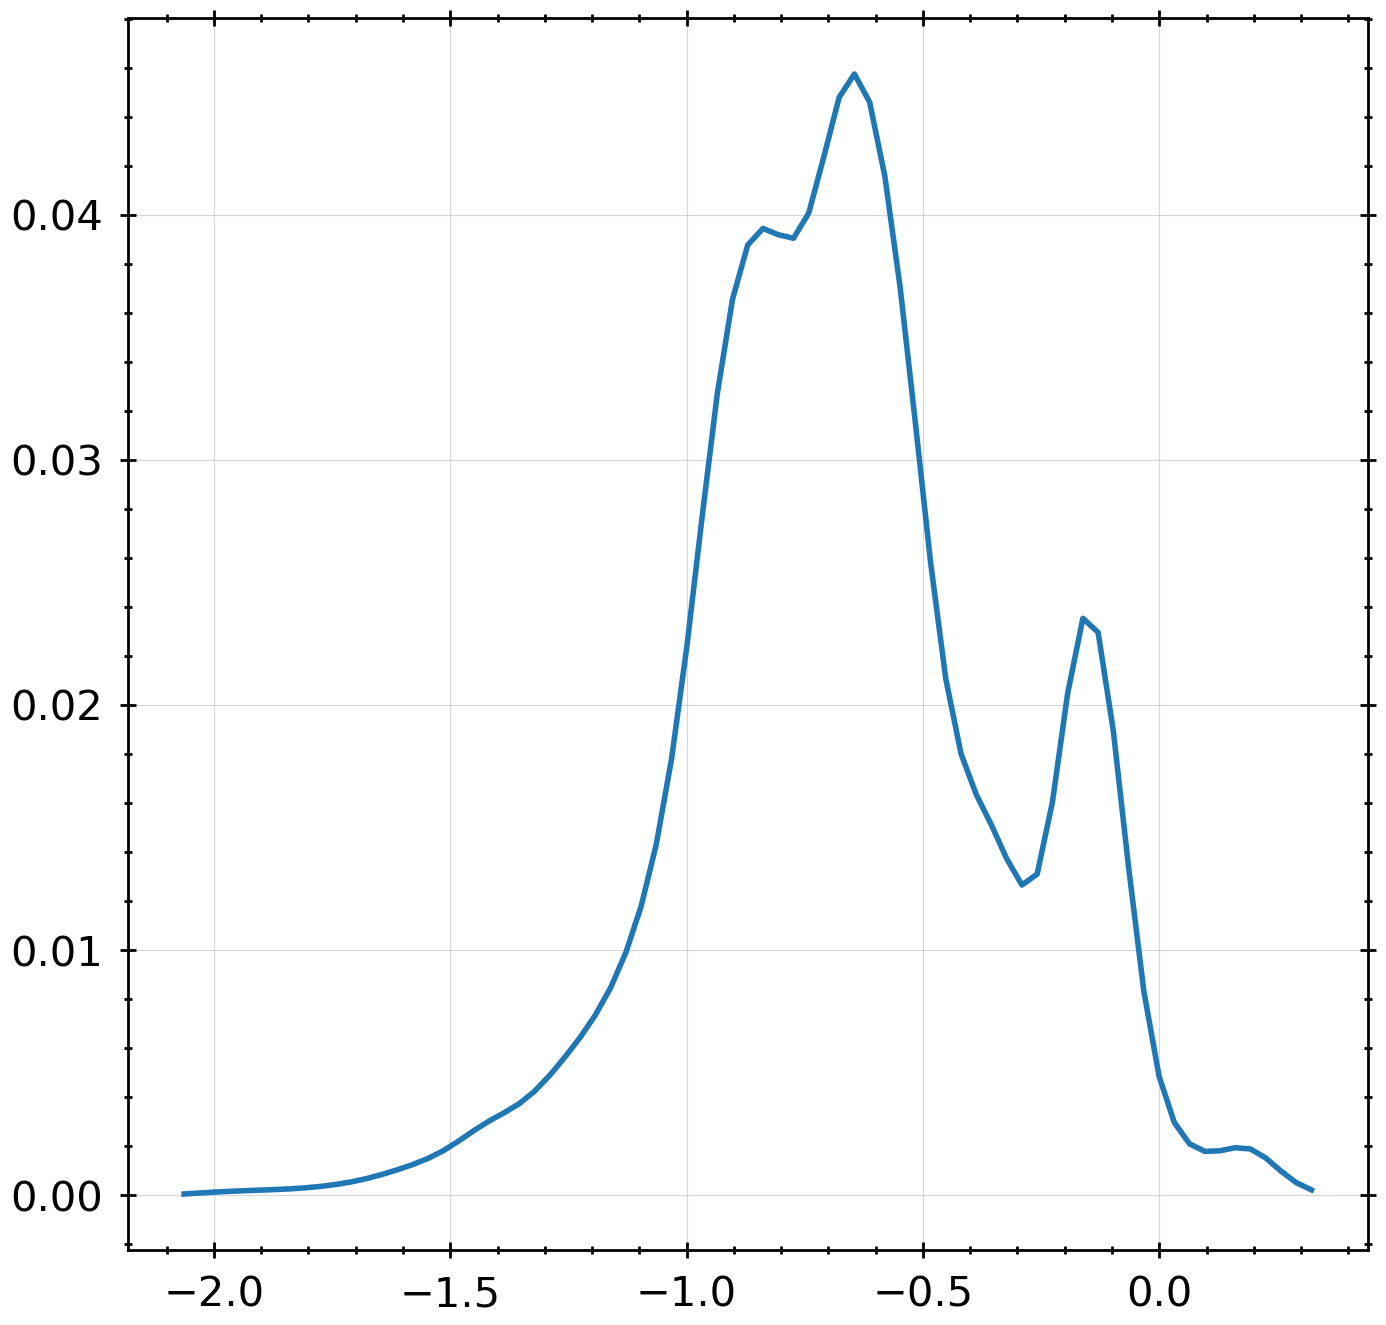

In [20]:
bins = 75

met_fig, met_ax = plt.subplots(1,1)

def do_metallicity_plot(weighted, plotting_data, label):
    # want to do a few checks with these histograms. that is, are they really area-preserving?
    logZZm = np.log10(dco_metallicities/0.012)

    weights = np.sum(plotting_data['all_weights'], axis=1) if weighted else np.ones_like(plotting_data['weights_at_current_z0'])
    dco_met_hist, dco_met_bins = np.histogram(
        logZZm,
        weights=weights,
        bins=bins,
        density=True
    )
    # print(np.sum(dco_met_hist*np.diff(dco_met_bins)))

    dco_metallicity_weighted_kde = stats.gaussian_kde(
        logZZm,
        weights=weights # TODO: multiply weights by mixture weights?
    )
    dco_met_bins_midpoints = (dco_met_bins[:-1]+dco_met_bins[1:])/2
    met_ax.plot(dco_met_bins_midpoints, dco_metallicity_weighted_kde(dco_met_bins_midpoints)*np.diff(dco_met_bins), label=label)
    # met_ax.fill_between(dco_met_bins_midpoints, dco_metallicity_weighted_kde(dco_met_bins_midpoints), label=label ,alpha=0.3)

    # met_ax.hist(
    #     logZZm,
    #     weights=weights,
    #     density=True,
    #     bins=bins,
    #     label=f'weighted: {weighted}',
    #     histtype='step'
    # )
do_metallicity_plot(True, fiducial_plotting_data, 'fiducial')
do_metallicity_plot(True, min_plotting_data, 'min')
do_metallicity_plot(True, max_plotting_data, 'max')
# do_metallicity_plot(False)

# met_ax.hist(
#     np.log10(dco_metallicities/0.012),
#     # weights=fiducial_plotting_data['weights_at_current_z0'],
#     density=True,
#     bins=bins,
#     label='Unweighted',
#     histtype='step'
# )
met_ax.legend()
# met_ax.set_xlabel(r'$\log_{10}{Z}$')
met_ax.set_xlabel(r'$\log_{10}(Z/Z_\odot)=x$')
met_ax.set_ylabel(r'$dN(x)$ Merger density 1/yr')
# met_ax.set_xscale('log')
met_ax.set_yscale('log')
# met_ax.set_xlim(10e-4,10)
met_fig.show()

# Metallicity Plot but binned by formation redshift

Sum is 0.9993591035989038
Sum is 0.9995599462229728
Sum is 0.9996994245258342
Sum is 0.9997930621456227
Sum is 0.9998545081152381
Sum is 0.9997528790792566


/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_78972/3460011183.py:53: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  form_ax.set_ylim(1e-4,0)
/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_78972/3460011183.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  form_fig.show()


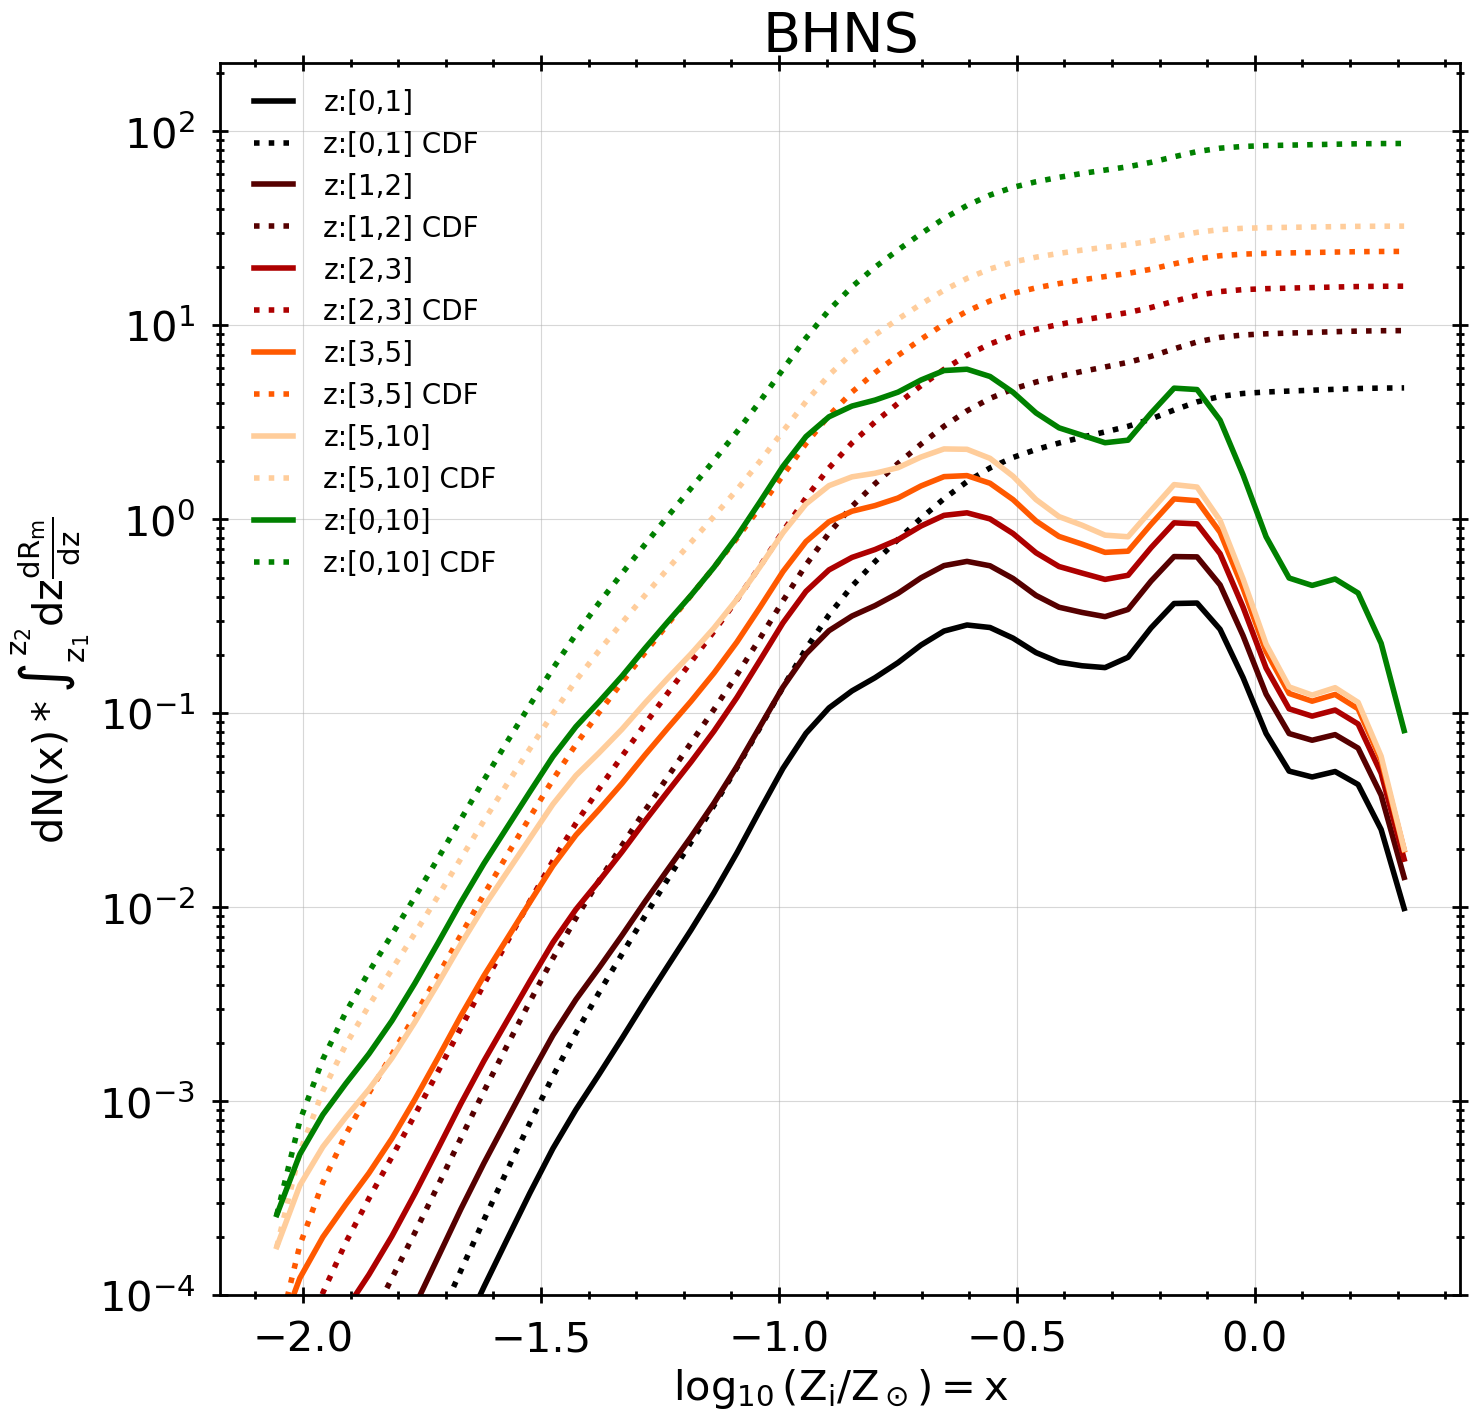

In [42]:
# basically same plot as above, but now we want to bin by redshift basically 
form_fig, form_ax = plt.subplots(1, 1)
PLOT_Z_LOG = True
Zm = np.log10(dco_metallicities/0.012) if PLOT_Z_LOG else dco_metallicities/0.012

all_weights = fiducial_plotting_data['all_weights']
redshifts = fiducial_plotting_data['redshifts']

# sum up to z
redshift_edges = np.array([0, 1, 2, 3, 5, 10])#np.linspace(0, 14, 5)#np.logspace(np.log10(0.001), np.log10(14), 5)
def do_metallicity_plot_to_redshift(left, right, color):
    w = np.sum(all_weights[:, (np.digitize(left, redshift_edges)-1):(np.digitize(right, redshift_edges)-1)], axis=1)
    dco_met_hist, dco_met_bins = np.histogram(
        Zm,
        weights=w,
        bins=50,
        density=True
    )
    # print(np.sum(dco_met_hist*np.diff(dco_met_bins)))

    dco_metallicity_weighted_kde = stats.gaussian_kde(
        Zm,
        weights=w # TODO: multiply weights by mixture weights?
    )

    dco_met_bins_midpoints = (dco_met_bins[:-1]+dco_met_bins[1:])/2
    dlogZ = np.diff(dco_met_bins)
    print(f'Sum is {dco_metallicity_weighted_kde(dco_met_bins_midpoints)@dlogZ}')
    plot_line = dco_metallicity_weighted_kde(dco_met_bins_midpoints)*dlogZ*np.sum(w)
    lab = f'z:[{left},{right}]'
    form_ax.plot(dco_met_bins_midpoints, plot_line, label=lab, color=color)
    # form_ax.fill_between(dco_met_bins_midpoints, plot_line, alpha=0.3)

    # cdf_ax = form_ax.twinx()
    form_ax.plot(dco_met_bins_midpoints, np.cumsum(plot_line), label=f'{lab} CDF', linestyle=':', color=color)
    # cdf_ax.tick_params(axis='y', labelcolor='red')
    # cdf_ax.set_yscale('log')
    # form_ax.axhline(plot_line.max())

color_bins = plt.cm.gist_heat(np.linspace(0, 0.9, len(redshift_edges)-1))

for i in range(len(redshift_edges)-1):
    do_metallicity_plot_to_redshift(redshift_edges[i], redshift_edges[i+1], color_bins[i])
do_metallicity_plot_to_redshift(0, 10, 'green')
form_ax.set_xlabel(r'$\log_{10}(Z_i/Z_\odot)=x$' if PLOT_Z_LOG else r'$Z_i/Z_\odot=x$')
# form_ax.set_xlabel(r'$\log_{10}(Z_i)$')
# form_ax.set_ylabel(r'$\frac{dN(x)}{d\log Z_i}*d\log Z_i=dN(x)~\frac{\text{merger density}}{\text{year}}$')
form_ax.set_ylabel(r'$dN(x)*\int_{z_1}^{z_2} dz \frac{dR_m}{dz}$')
# form_ax.set_ylabel(r'$N(x)$ Density CDF')
# form_ax.set_xscale('log')
form_ax.set_yscale('log')
form_ax.set_title(f'{TYPES}')
form_ax.set_ylim(1e-4,0)
form_ax.legend()
form_fig.show()